from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import griddata
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

In [30]:
rawdata = loadmat("ERB_training_data_500m_20240403.mat")
keys = [k for k in rawdata.keys() if k[0]!= '_']
df = pd.DataFrame({k: rawdata[k].flatten() for k in keys})

In [32]:
Xcols = ['fveg','fsca','elev', 'northness', 'topo_index']
Ycol = 'snow_depth'

# Step 1
Lets make the forest

In [152]:
my_rf = RandomForestRegressor(100, min_samples_leaf=200, max_features=2, oob_score=True) 

In [153]:
my_rf.fit(df[Xcols], df[Ycol])

RandomForestRegressor(max_features=2, min_samples_leaf=200, oob_score=True)

And look at the trees

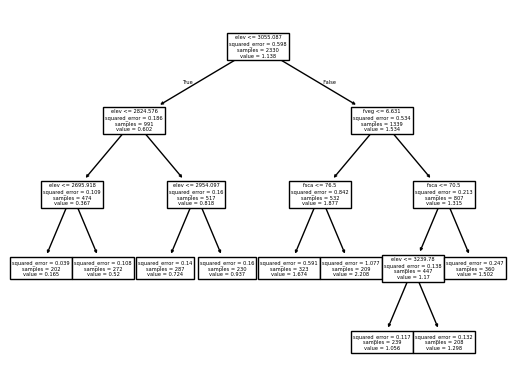

In [154]:
plot_tree(my_rf.estimators_[0], feature_names=Xcols);

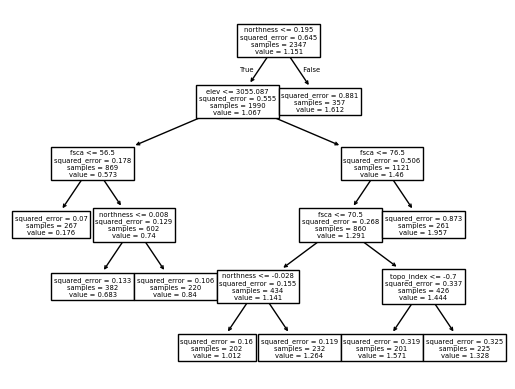

In [155]:
plot_tree(my_rf.estimators_[22], feature_names=Xcols);

**1.1** First node is different, sampling a few I only got elevation or topo index however.

# Step 2 
Now let us predict

In [156]:
prediction = my_rf.predict(df[:1][Xcols].values)[0]
true = df[:1][Ycol].values[0]
print(f"Random Forest predicted snow depth of {prediction:.2}.  Actually it's {true:.2}")

Random Forest predicted snow depth of 1.7.  Actually it's 3.4


/home/jo/micromamba/envs/mlhydro/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Lets vary just elevation.  We have to modify our datasaet

In [109]:
def variable_focus(df, cols, focus_var):
    medians = df[cols].median()
    focused = df[focus_var]
    new_df = {c: [medians[c]]*len(focused) for c in cols}
    new_df[focus_var] = focused
    return pd.DataFrame(new_df)

In [110]:
elev_focus = variable_focus(df, Xcols, 'elev')

In [157]:
elevation_predictions = my_rf.predict(elev_focus[Xcols])

Text(0.5, 1.0, 'Random Forest Predictions varying just elevation')

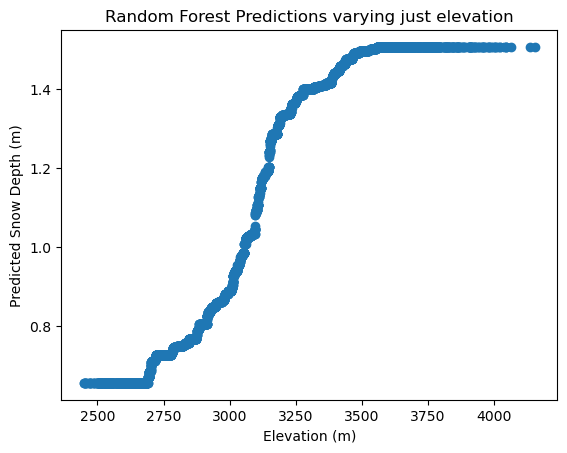

In [173]:
plt.plot(df['elev'], elevation_predictions, 'o')
plt.xlabel("Elevation (m)")
plt.ylabel("Predicted Snow Depth (m)")
plt.title("Random Forest Predictions varying just elevation")

**2.2** Seems like this makes sense

# Question 3
Lets look at error. First lets create forests with different numbers and sizes of trees, and calculate OOB errors.

In [166]:
num_trees = np.arange(15, 150)
stump_oob_scores = np.zeros(num_trees.shape)
stump_oob_predictions = np.zeros(num_trees.shape)
rw_oob_scores = np.zeros(num_trees.shape)
rw_oob_predictions = np.zeros(num_trees.shape)
for i, trees in enumerate(num_trees):
    srf = RandomForestRegressor(trees, min_samples_leaf=200, max_features=2, oob_score=True) 
    srf.fit(df[Xcols], df[Ycol])
    rwrf = RandomForestRegressor(trees, min_samples_leaf=20, max_features=2, oob_score=True) 
    rwrf.fit(df[Xcols], df[Ycol])
    stump_oob_scores[i] = srf.oob_score_
    stump_oob_predictions[i] = mean_squared_error(df[Ycol], srf.oob_prediction_)
    rw_oob_scores[i] = rwrf.oob_score_
    rw_oob_predictions[i] = mean_squared_error(df[Ycol], rwrf.oob_prediction_)
oob_df = pd.DataFrame({'num trees': np.concatenate([num_trees, num_trees]),
                       'OOB scores': np.concatenate([stump_oob_scores,rw_oob_scores]),
                       'OOB RMSE': np.sqrt(np.concatenate([stump_oob_predictions, rw_oob_predictions])),
                       'tree type': np.concatenate([['stump']*len(num_trees),['redwood']*len(num_trees)])
                      })
                                  


/home/jo/micromamba/envs/mlhydro/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/jo/micromamba/envs/mlhydro/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/jo/micromamba/envs/mlhydro/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/jo/micromamba/envs/mlhydro/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/jo/micromamba/envs/mlhydro/lib/python3.13/site-package

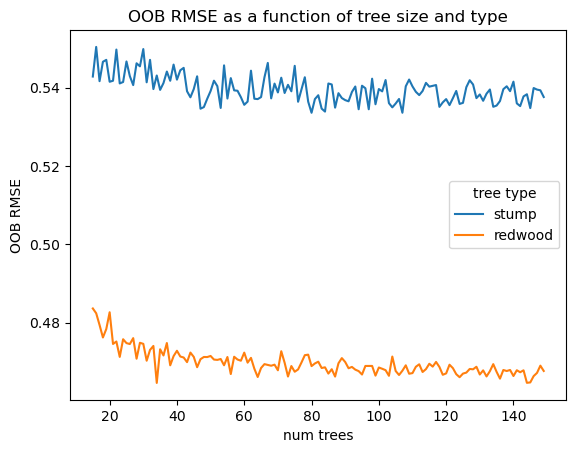

In [180]:
sns.lineplot(data=oob_df, x='num trees', y='OOB RMSE', hue='tree type').set(title="OOB RMSE as a function of tree size and type");

Generally more trees means less error.  This is good and what we would expect.  However bigger trees do much more to reduce error.

# 4
Now lets look at our predictions

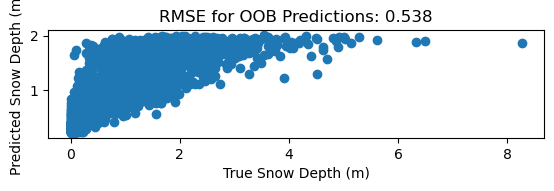

In [183]:
plt.plot(df[Ycol], my_rf.oob_prediction_, 'o')
plt.xlabel('True Snow Depth (m)')
plt.ylabel('Predicted Snow Depth (m)')
plt.title(f"RMSE for OOB Predictions: {np.sqrt(mean_squared_error(df[Ycol], my_rf.oob_prediction_)):.3}")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

This error looks like it matches the RMSE for a stump tree with around 100 nodes, which is what it is.

# 5

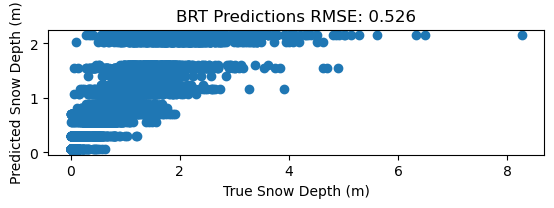

In [184]:
brt = DecisionTreeRegressor(min_samples_leaf=200)
brt.fit(df[Xcols], df[Ycol])
brt_preds = brt.predict(df[Xcols])
rmse = np.sqrt(mean_squared_error(df[Ycol], brt_preds))
plt.plot(df[Ycol], brt_preds, 'o')
plt.xlabel("True Snow Depth (m)")
plt.ylabel("Predicted Snow Depth (m)")
plt.title(f"BRT Predictions RMSE: {rmse:.3}")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

This looks a lot like the random forest just slightly binned.